<a href="https://colab.research.google.com/github/smiledinisa/pytorch_learning/blob/master/quantized_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
import copy
import matplotlib.pyplot as plt
import numpy as np
import os
import time

plt.ion()


In [4]:
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [2]:
import torch


In [7]:
a = torch.tensor([[2,3,4,5],[3,5,6,7]])
a

tensor([[2, 3, 4, 5],
        [3, 5, 6, 7]])

In [10]:
_,b =torch.max(a,1)
b

tensor([3, 3])

In [5]:
import torch
from torchvision import transforms, datasets

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/drive/My Drive/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                              shuffle=True, num_workers=8)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

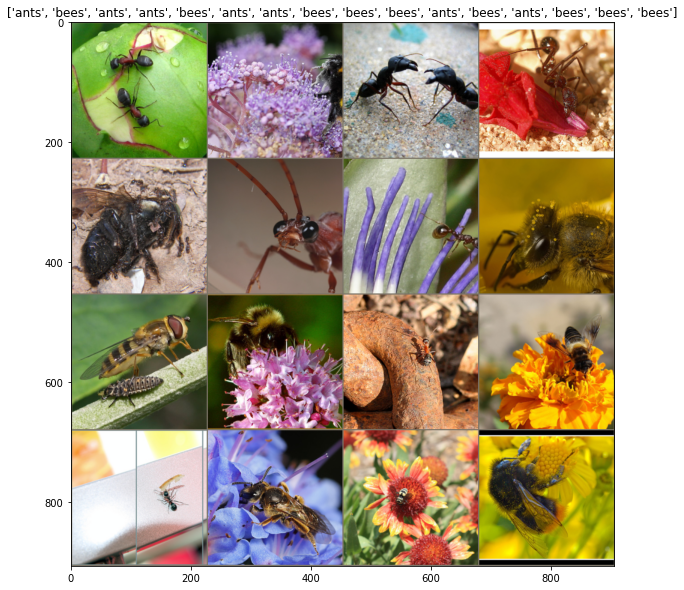

In [8]:
import torchvision

def imshow(inp, title=None, ax=None, figsize=(5, 5)):
  """Imshow for Tensor."""
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1) #clip函数。
  if ax is None:
    fig, ax = plt.subplots(1, figsize=figsize)
  ax.imshow(inp)
  # ax.set_xticks([]) #x轴和y轴都不用显示刻度。
  # ax.set_yticks([])
  if title is not None:
    ax.set_title(title)

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs, nrow=4)  #batchsize = 16 ,每行4个。

fig, ax = plt.subplots(1, figsize=(10, 10))
imshow(out, title=[class_names[x] for x in classes], ax=ax) #class_name 标识符和字符串对应的字典。

In [9]:
# Support Function for Model Training
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, device='cpu'):
  """
  Support function for model training.

  Args:
    model: Model to be trained
    criterion: Optimization criterion (loss)
    optimizer: Optimizer to use for training
    scheduler: Instance of ``torch.optim.lr_scheduler``
    num_epochs: Number of epochs
    device: Device to run the training on. Must be 'cpu' or 'cuda'
  """
  since = time.time()

  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()  # Set model to training mode
      else:
        model.eval()   # Set model to evaluate mode

      running_loss = 0.0
      running_corrects = 0

      # Iterate over data.
      for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        # track history if only in train
        with torch.set_grad_enabled(phase == 'train'):
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)  #找出最大的结果标签索引。batch x nlabels
          loss = criterion(outputs, labels)

          # backward + optimize only if in training phase
          if phase == 'train':
            loss.backward()
            optimizer.step()

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
      if phase == 'train':
        scheduler.step()  #调整学习率。

      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.double() / dataset_sizes[phase]

      print('{} Loss: {:.4f} Acc: {:.4f}'.format(
        phase, epoch_loss, epoch_acc))

      # deep copy the model
      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())

    print()

  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
  print('Best val Acc: {:4f}'.format(best_acc))

  # load best model weights
  model.load_state_dict(best_model_wts)
  return model

In [10]:
#Support Function for Visualizing the Model Predictions

def visualize_model(model, rows=3, cols=3):
  was_training = model.training
  model.eval()
  current_row = current_col = 0
  fig, ax = plt.subplots(rows, cols, figsize=(cols*2, rows*2))

  with torch.no_grad():
    for idx, (imgs, lbls) in enumerate(dataloaders['val']):
      imgs = imgs.cpu()
      lbls = lbls.cpu()

      outputs = model(imgs)
      _, preds = torch.max(outputs, 1)

      for jdx in range(imgs.size()[0]):
        imshow(imgs.data[jdx], ax=ax[current_row, current_col])
        ax[current_row, current_col].axis('off')
        ax[current_row, current_col].set_title('predicted: {}'.format(class_names[preds[jdx]]))

        current_col += 1
        if current_col >= cols:
          current_row += 1
          current_col = 0
        if current_row >= rows:
          model.train(mode=was_training)
          return
    model.train(mode=was_training)

In [11]:
# Part 1. Training a Custom Classifier based on a Quantized Feature Extractor

import torchvision.models.quantization as models

# You will need the number of filters in the `fc` for future use.
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_fe = models.resnet18(pretrained=True, progress=True, quantize=True)
num_ftrs = model_fe.fc.in_features



Downloading: "https://download.pytorch.org/models/quantized/resnet18_fbgemm_16fa66dd.pth" to /root/.cache/torch/hub/checkpoints/resnet18_fbgemm_16fa66dd.pth


In [12]:
from torch import nn

def create_combined_model(model_fe):
  # Step 1. Isolate the feature extractor.
  model_fe_features = nn.Sequential(
    model_fe.quant,  # Quantize the input
    model_fe.conv1,
    model_fe.bn1,
    model_fe.relu,
    model_fe.maxpool,
    model_fe.layer1,
    model_fe.layer2,
    model_fe.layer3,
    model_fe.layer4,
    model_fe.avgpool,
    model_fe.dequant,  # Dequantize the output
  )

  # Step 2. Create a new "head"
  new_head = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(num_ftrs, 2),
  )

  # Step 3. Combine, and don't forget the quant stubs.
  new_model = nn.Sequential(
    model_fe_features,
    nn.Flatten(1),
    new_head,
  )
  return new_model

In [13]:
import torch.optim as optim
new_model = create_combined_model(model_fe)
new_model = new_model.to('cpu')

criterion = nn.CrossEntropyLoss()

# Note that we are only training the head.
optimizer_ft = optim.SGD(new_model.parameters(), lr=0.01, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Epoch 0/4
----------
train Loss: 0.2803 Acc: 0.9180
val Loss: 0.2705 Acc: 0.9542

Epoch 1/4
----------
train Loss: 0.2166 Acc: 0.9344
val Loss: 0.2560 Acc: 0.9542

Epoch 2/4
----------
train Loss: 0.2268 Acc: 0.9549
val Loss: 0.2484 Acc: 0.9477

Epoch 3/4
----------
train Loss: 0.1894 Acc: 0.9508
val Loss: 0.4700 Acc: 0.9020

Epoch 4/4
----------
train Loss: 0.2924 Acc: 0.9426
val Loss: 0.3678 Acc: 0.9346

Training complete in 1m 21s
Best val Acc: 0.954248


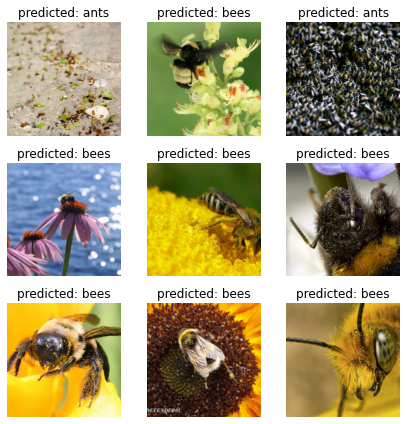

In [15]:
new_model = train_model(new_model, criterion, optimizer_ft, exp_lr_scheduler,
                        num_epochs=5, device='cpu')

visualize_model(new_model)
plt.tight_layout()

In [16]:
# Part 2. Finetuning the Quantizable Model

# The pretrained feature extractor must be quantizable. To make sure it 
# is quantizable, perform the following steps:



1.   Fuse (Conv, BN, ReLU), (Conv, BN), and (Conv, ReLU) using torch.quantization.fuse_modules.

2.   Connect the feature extractor with a custom head. This requires dequantizing the output of the feature extractor.


3.   Insert fake-quantization modules at appropriate locations in the feature extractor to mimic（模仿） quantization during training.



In [17]:
# Step 1 model.train() model.fuse_model() 
# Step 2 model_ft = create_combined_model(model) model_ft[0].qconfig = torch.quantization.default_qat_qconfig 
# Use default QAT configuration 
# Step 3 model_ft = torch.quantization.prepare_qat(model_ft, inplace=True)

In [21]:
import torchvision.models.quantization as models
quantize=False
model = models.resnet18(pretrained=True, progress=True, quantize=False)
num_ftrs = model.fc.in_features
model.train()
model.fuse_model()
model_ft = create_combined_model(model) 
model_ft[0].qconfig = torch.quantization.default_qat_qconfig
model_ft = torch.quantization.prepare_qat(model_ft, inplace=True)


# Step 4. Fine tune the model
for param in model_ft.parameters():
  param.requires_grad = True

model_ft.to(device)  # We can fine-tune on GPU if available

criterion = nn.CrossEntropyLoss()

# Note that we are training everything, so the learning rate is lower
# Notice the smaller learning rate
optimizer_ft = optim.SGD(model_ft.parameters(), lr=1e-3, momentum=0.9, weight_decay=0.1)

# Decay LR by a factor of 0.3 every several epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.3)

model_ft_tuned = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                             num_epochs=5, device=device)

Epoch 0/4
----------
train Loss: 0.6462 Acc: 0.6762
val Loss: 0.3105 Acc: 0.9150

Epoch 1/4
----------
train Loss: 0.3710 Acc: 0.8320
val Loss: 0.2230 Acc: 0.9216

Epoch 2/4
----------
train Loss: 0.2161 Acc: 0.9098
val Loss: 0.1988 Acc: 0.9412

Epoch 3/4
----------
train Loss: 0.1377 Acc: 0.9426
val Loss: 0.1870 Acc: 0.9412

Epoch 4/4
----------
train Loss: 0.1466 Acc: 0.9426
val Loss: 0.2067 Acc: 0.9216

Training complete in 0m 28s
Best val Acc: 0.941176


In [23]:
# Step 5. Convert to quantized model
from torch.quantization import convert
model_ft_tuned.cpu()

model_quantized_and_trained = convert(model_ft_tuned, inplace=False)

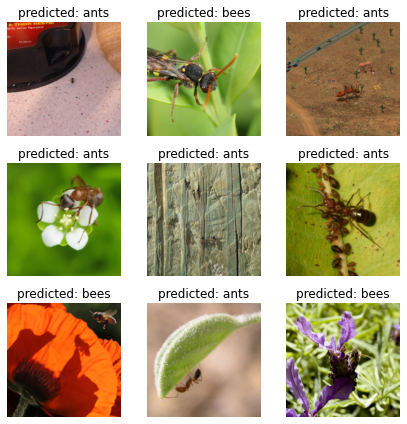

In [24]:
visualize_model(model_quantized_and_trained)

plt.ioff()
plt.tight_layout()
plt.show()